### Name: Rahul Rana   
### UNI: rr3087   
### EMAIL: rr3087@columbia.edu
### Assignment: HW4

In [ ]:
### References: https://chunml.github.io/ChunML.github.io/project/Sequence-To-Sequence/

# KERAS VERSION = 2.0.8

# Sequence to Sequence Modelling

**Note**: All code should be in Python3. Keras version should be 2.0.4. The directory structure on the bitbucket repo should be exactly same as the hw4.zip provided to you (with the exception of data directory. Do not upload it). To push the code to remote repo, use the same instructions as given in HW0. **Double check you remote repo for correct directory structure. We won't consider any regrade requests based on wrong directory structure penalty. Again, do not upload data to your bitbucket repo ** <br>
**The data provided to you should not be used for any other purpose than this course. You must not distribute it or upload it to any public platform.**

![title](seq2seq.png)

In this assignment, we are going to solve the problem of summarization using a sequence to sequence model. In a sequence to sequence problem, we have an encoder and a decoder. We feed the sequence of word embeddings to an encoder and train decoder to learn the summaries. We will be seeing 2 types of encoder decoder architectures in this assignment

# Preparing Inputs

The first part of the assignment is to prepare data. You are given training data in train_article.txt, in which each line is the first sentence from an article, and training summary sentences in train_title.txt, which are the corresponding titles of the article. You will be training the model to predict the title of an article given the first sentence of that article, where title generation is a summarization task. Let us limit the maximum vocabulary size to 20000 and maximum length of article to 200 (These are just initial params to get you started and we recommend experimenting, to improve your scores after you are done with your first implementation)

In [2]:
MAX_LEN = 30
VOCAB_SIZE = 20000

Write a function which takes article file, summary file, maximum length of sentence and vocabulary size and does the following
* Create vocabulary: Take most frequent VOCAB_SIZE number of words from article file. Add two special symbols ZERO at start and UNK at end to finally have VOCAB_SIZE + 2 words. Use this array as idx2word. Repeat the process for summary data to create another idx2word corresponding to it. 
* Using the above idx2word for both article and summary data, create word2idx, which will map every word to its index in idx2word array. 
* Convert the words in the article and summary data to their corresponding index from word2idx. If a word is not present in the vocab, use the index of UNK. 
* After the above preprocessing, each sentence in article and summary data should be a list of indices
* Now find the max length of a sentence (which is basically number ofs indices in a sentence) in article data. Pad every sentence in article data to that length, so that all sentences are of same length. You may use pad_sequences function provided by keras. Do the same for title data.
* return the following outputs transformed article data, vocab size of article data, idx2word(articledata), word2idx(articledata),transformed summary data, vocab size of summary data, idx2word(summarydata), word2idx(summarydata)

In [3]:
from collections import Counter
import re
import itertools
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.layers import LSTM, TimeDistributed, RepeatVector, Input, Dense, Activation, Embedding, Bidirectional
from keras.layers.core import Reshape
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, TensorBoard
import numpy as np
import operator

Using TensorFlow backend.


In [4]:

def load_data(article, summary, max_len, vocab_size):
   
    t1 = Tokenizer(num_words=20000)
    t1.fit_on_texts(article)
    article_words = sorted(t1.word_index.items(), key=operator.itemgetter(1))[0:vocab_size]
    id2w_ad = ['ZERO'] + [i[0] for i in article_words]
       
    t_ad = []
    for sentence in article:
        sentence_words = text_to_word_sequence(sentence)
        sentence_words_idxs = [id2w_ad.index(word) if word in id2w_ad else id2w_ad.index('unk') for word in sentence_words]
        t_ad.append(sentence_words_idxs)
    
    max_len_ad = max(len(i) for i in t_ad)
    
    w2id_ad = list(range(0, len(id2w_ad)))
    
    vs_ad = len(id2w_ad)

    t2 = Tokenizer(num_words=20000)
    t2.fit_on_texts(summary)
    summary_words = sorted(t2.word_index.items(), key=operator.itemgetter(1))[0:vocab_size]
    id2w_sd = ['ZERO'] + [i[0] for i in summary_words]
    
    t_sd = []
    for sentence in summary:
        sentence_words = text_to_word_sequence(sentence)
        sentence_word_idxs = [id2w_sd.index(word) if word in id2w_sd else id2w_sd.index('unk') for word in sentence_words]
        t_sd.append(sentence_word_idxs) 
    
    max_len_sd = max(len(i) for i in t_sd)
    
    max_len_pad = max(max_len_ad, max_len_sd)
    
    t_ad = pad_sequences(t_ad, maxlen=max_len, truncating='post', padding='post')
    t_sd = pad_sequences(t_sd, maxlen=max_len, truncating='post', padding='post')
    
    w2id_sd = list(range(0, len(id2w_sd)))
    
    vs_sd = len(id2w_sd)
    
    
    return t_ad, vs_ad, id2w_ad, w2id_ad, t_sd, vs_sd, id2w_sd, w2id_sd
#complete this function using details as above

Now use the above function to load the training data from article and summary (i.e. title) files. Do note that, based on your model architecture, you may need to further one-hot vectorize your input to the model

In [5]:
# TO-DO
### loading the training data

with open ('data/train_article.txt') as f:
    tr_article = f.read().splitlines()
    
with open ('data/train_title.txt') as f:
    tr_summary = f.read().splitlines()
    
t_ad, vs_ad, id2w_ad, w2id_ad, t_sd, vs_sd, id2w_sd, w2id_sd = load_data(tr_article, tr_summary, MAX_LEN, VOCAB_SIZE)           

In [6]:
def generator(features, labels, batch_size):
    batch_features = np.zeros((batch_size, 30)) 
    batch_labels = np.zeros((batch_size, 30, 20001))
    while True:
        for i in range(batch_size):
            index = np.random.choice(len(features), 1)[0]
#             batch_features[i] = to_categorical(features[index], num_classes=20002) ## one-hot encoding for use without embedding layer
            batch_features[i] = features[index] ## sequences for use with embedding layer
            batch_labels[i] = to_categorical(labels[index], num_classes=20001)
        yield batch_features, batch_labels

# Unidirectional LSTM Encoder Decoder 

Define the parameters for your LSTM encoder decoder model. 

In [7]:
BATCH_SIZE = 200
NUM_LAYERS = 2 ## no. of LSTMs in encoder and decoder
HIDDEN_DIM = 256 ### 200-400 & 100-300 for with attention
EPOCHS = 120

Create a Unidirectional encoder decoder LSTM model in create_model function. The model should have a LSTM Unidirectional layer as encoder and a LSTM decoder.
Use categorical_cross_entropy loss and experiment with different optimizers to improve your score.

In [8]:

def create_UniLSTM(X_vocab_len, X_max_len, y_vocab_len, y_max_len, hidden_size, num_layers):
    # TO-DO
    # create and return the model for unidirectional LSTM encoder decoder
    model = Sequential()
#     model.add(Embedding(X_vocab_len, 1000, input_length=X_max_len)) 93% val_acc
    model.add(Embedding(X_vocab_len, 300, input_length=X_max_len, mask_zero=True)) ## 96% with both on and 2 LSTM decoders
    model.add(Bidirectional(LSTM(hidden_size, activation='tanh')))

    model.add(RepeatVector(y_max_len)) ## repeat vector is what is separating the encoder from the decoder
    
    model.add(LSTM(hidden_size, return_sequences=True, activation='tanh'))
    model.add(LSTM(hidden_size, return_sequences=True, activation='tanh'))
    model.add(TimeDistributed(Dense(y_vocab_len, activation='softmax'))) ### time-distributed is supposed to be used, since it captures over each time-step
    
    model.compile(optimizer='rmsprop',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    
    
    return model

# Train the Model

Now that we have everything in place, we can run our model. We recommend training the model in batches instead of training on all 50,000 article-title pairs at once, if you encounter memory contraints

In [9]:
# TO-DO
### loading the test data

with open('data/test_article.txt') as f:
    te_article = f.read().splitlines()

t_ad_test_unpad = []
for sentence in te_article:
    sentence_words = text_to_word_sequence(sentence)
    sentence_words_idxs = [id2w_ad.index(word) if word in id2w_ad else id2w_ad.index('unk') for word in sentence_words]
    t_ad_test_unpad.append(sentence_words_idxs)
t_ad_test = pad_sequences(t_ad_test_unpad, maxlen=MAX_LEN, truncating='post', padding='post')
     
with open('data/test_title.txt') as f:
    te_summary = f.read().splitlines()

t_sd_test_unpad = []
t_sd_test_rouge = []
for sentence in te_summary:
    sentence_words = text_to_word_sequence(sentence)
    t_sd_test_rouge.append(sentence_words)
    sentence_words_idxs = [id2w_sd.index(word) if word in id2w_sd else id2w_sd.index('unk') for word in sentence_words]
    t_sd_test_unpad.append(sentence_words_idxs)
t_sd_test = pad_sequences(t_sd_test_unpad, maxlen=MAX_LEN, truncating='post', padding='post')
        

In [28]:
model_nat = create_UniLSTM(20001, MAX_LEN, 20001, MAX_LEN, HIDDEN_DIM, 2)

model_nat.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 300)           6000300   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 512)               1140736   
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 30, 512)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 30, 256)           787456    
_________________________________________________________________
lstm_6 (LSTM)                (None, 30, 256)           525312    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 20001)         5140257   
Total params: 13,594,061
Trainable params: 13,594,061
Non-trainable params: 0
________________________________________________________________

In [ ]:
### USING BIDIRECTIONAL LSTM
wt_dir = "weights/"
model_name = 'model_best_nat'
# early_stopping =EarlyStopping(monitor='loss', patience=10)
bst_model_path = wt_dir + model_name + '.h5'
model_checkpoint = ModelCheckpoint(bst_model_path, monitor='loss', save_best_only=True, save_weights_only=True)
# tensorboard = TensorBoard(log_dir = 'logs/', histogram_freq=0, batch_size=200)

## not validating on the test set since I am monitoring the training loss.

model_nat.fit_generator(generator(t_ad, t_sd, batch_size=200),
                    steps_per_epoch = len(t_ad)/200,
#                     steps_per_epoch=1,
                    epochs=120,
#                     validation_data = generator(t_ad_test, t_sd_test, batch_size=200),
#                     validation_steps = len(t_ad_test)/200,
#                     validation_steps=1,
                    verbose=1,
                    callbacks = [model_checkpoint]
                    )

Epoch 1/120
250/250 [==============================] - 412s - loss: 2.2515 - acc: 0.7555   
Epoch 2/120
250/250 [==============================] - 447s - loss: 1.9973 - acc: 0.7604   
Epoch 3/120
250/250 [==============================] - 420s - loss: 1.9785 - acc: 0.7611   
Epoch 4/120
250/250 [==============================] - 358s - loss: 1.9657 - acc: 0.7619   
Epoch 5/120
250/250 [==============================] - 376s - loss: 1.9572 - acc: 0.7625   
Epoch 6/120
250/250 [==============================] - 352s - loss: 1.9528 - acc: 0.7625   
Epoch 7/120
250/250 [==============================] - 402s - loss: 1.9419 - acc: 0.7634   
Epoch 8/120
250/250 [==============================] - 371s - loss: 1.9364 - acc: 0.7638   
Epoch 9/120
250/250 [==============================] - 377s - loss: 1.9372 - acc: 0.7634   
Epoch 10/120
250/250 [==============================] - 379s - loss: 1.9245 - acc: 0.7645   
Epoch 11/120
250/250 [==============================] - 375s - loss: 1.9269 - a

In [81]:
model_nat.load_weights('weights/model_best_nat.h5')

pred_total_nat = model_nat.predict(t_ad_test)
pred_idx_total_nat = np.argmax(pred_total_nat, axis=2)
pred_idx_total_nat = [filter(lambda i: i!=0, ix) for ix in pred_idx_total_nat]

ref_sent_nat = [' '.join(t_sd_test_rouge[i]) for i in range(len(t_sd_test))]
hypo_sent_nat = [' '.join(np.array(id2w_sd)[pred_idx_total_nat[i]]) for i in range(len(t_sd_test))]

# Evaluation using Rouge score 

Now that you have trained the model, load the test data i.e. test_article.txt and corresponding reference titles test_title.txt. Process test_article.txt in the same way as you did your train_article.txt. Then use your model to predict the titles.
When you have your model predicted titles, and the reference titles (test_title.txt) calculate the Rouge score corresponding to your predictions. <br>
You should install rouge by executing "pip3 install rouge". Refer https://pypi.python.org/pypi/rouge/0.2.1 for documentation on how to use the package.

In [26]:
################################ BEST MODEL
from rouge import Rouge
rouge = Rouge()

hyps, refs = map(list, zip(*[[ref_sent_nat[i], hypo_sent_nat[i]] for i in range(len(t_sd_test))])) ### rouge for multiple values
                     
rouge.get_scores(hyps, refs, avg=True)

{'rouge-1': {'f': 0.18706348270852552,
  'p': 0.17149708017791832,
  'r': 0.22246877447948876},
 'rouge-2': {'f': 0.065401080192244734,
  'p': 0.064993846827775398,
  'r': 0.067892857142857144},
 'rouge-l': {'f': 0.16126738812887426,
  'p': 0.16647388616837974,
  'r': 0.1743566762602477}}

# Tensorboard Visualization 

We recommended training the data in batches because of our tensor constraints. This also presents us with a challenge of visualizing loss function and accuracy change with each epoch. Keras has an inbuilt function called fit_generator which takes in a generator function and gives the required batch for training. Use this Function to load data in batches of 100 for 200 steps_per_epoch. Run the training for 10 epochs. Use Keras callbacks to send data to tensorboad (you can look this up online). 

Once your training is done. Go to command line and run tensorboard. By default Tensorboard opens on 6006 port. Do remember to allow traffic on the same for gcloud (like you did for previous assignment). You can see various metrics depending on what you want to track like loss, accuracy, validation loss and validation accuracy over epochs. Attach the plots of loss and accuracy from the tensorboard display in the notebook

In [ ]:
# TO-DO
#  ![title](images/acc_20k.JPG)

![title](images/acc_20k.JPG)

![title](images/loss_20k.JPG)

In [10]:
model_tb = create_UniLSTM(20001, MAX_LEN, 20001, MAX_LEN, HIDDEN_DIM, 2)

model_tb.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 300)           6000300   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               1140736   
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 30, 512)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 256)           787456    
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 256)           525312    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 20001)         5140257   
Total params: 13,594,061
Trainable params: 13,594,061
Non-trainable params: 0
________________________________________________________________

In [11]:
### taking the 1st 20,000 samples for tensorboard visualization
t_ad_tb = t_ad[0:20000]
t_sd_tb = t_sd[0:20000]

In [13]:

# model_checkpoint = ModelCheckpoint(bst_model_path, monitor='loss', save_best_only=True, save_weights_only=True)
tensorboard = TensorBoard(log_dir = 'logs/', histogram_freq=0, batch_size=200)
### tensorboard for 10 epochs

## not validating on the test set since I am monitoring the training loss.

model_tb.fit_generator(generator(t_ad_tb, t_sd_tb, batch_size=100),
                    steps_per_epoch = len(t_ad_tb)/100, ### 200 steps_per_epoch
#                     steps_per_epoch=1,
                    epochs=10,
#                     validation_data = generator(t_ad_test, t_sd_test, batch_size=200),
#                     validation_steps = len(t_ad_test)/200,
#                     validation_steps=1,
                    verbose=1,
                    callbacks = [tensorboard]
                    )

Epoch 1/10
200/200 [==============================] - 226s - loss: 2.3687 - acc: 0.7516   
Epoch 2/10
200/200 [==============================] - 260s - loss: 2.0553 - acc: 0.7581   
Epoch 3/10
200/200 [==============================] - 276s - loss: 2.0278 - acc: 0.7592   
Epoch 4/10
200/200 [==============================] - 297s - loss: 2.0232 - acc: 0.7582   
Epoch 5/10
200/200 [==============================] - 257s - loss: 2.0113 - acc: 0.7579   
Epoch 6/10
200/200 [==============================] - 251s - loss: 1.9971 - acc: 0.7591   
Epoch 7/10
200/200 [==============================] - 239s - loss: 1.9966 - acc: 0.7583   
Epoch 8/10
200/200 [==============================] - 242s - loss: 1.9827 - acc: 0.7594   
Epoch 9/10
200/200 [==============================] - 240s - loss: 1.9890 - acc: 0.7582   
Epoch 10/10
200/200 [==============================] - 458s - loss: 2.0117 - acc: 0.7576   


# Unidirectional LSTM Encoder Decoder With Attention 

Define the parameters for your LSTM encoder decoder model with attention

In [14]:
MAX_LEN_AT = 30
VOCAB_SIZE_AT = 10000

In [15]:
BATCH_SIZE_AT = 400
NUM_LAYERS_AT = 2
HIDDEN_DIM_AT = 128
EPOCHS_AT = 100

You would've observed that the summaries are not yet perfect. This is because in encoder decoder architecture, only the final state of encoder is used to calculate the probabilities. We now move to a more general approach called attention based approach. In this, we take a weighted sum of all weights of encoder instead of just the last one. You are already provided an attention_decoder.py file with AttentionDecoder. Add this layer on top of your encoder and run the same experiment as before. For this part, you don't need to worry about return_probabilities argument to create_UniLSTMwithAttention function. Just pass it as an argument to your attention decoder layer. When return_probabilities is false, the attention decoder returns prediction model, which is what you need for this part of the assignment. When return_probabilities is true, the attention decoder returns the probability model, which you will be using later in the Analysis part of this assignment

In [16]:
def load_data_attention(article, summary, max_len, vocab_size):
    
   
    t1 = Tokenizer(num_words=10000)
    t1.fit_on_texts(article)
    article_words = sorted(t1.word_index.items(), key=operator.itemgetter(1))[0:vocab_size]
    id2w_ad = ['ZERO'] + [i[0] for i in article_words]
    
       
    t_ad = []
    for sentence in article:
        sentence_words = text_to_word_sequence(sentence)
        sentence_words_idxs = [id2w_ad.index(word) if word in id2w_ad else id2w_ad.index('unk') for word in sentence_words]
        t_ad.append(sentence_words_idxs)
    
    max_len_ad = max(len(i) for i in t_ad)
    
    w2id_ad = list(range(0, len(id2w_ad)))
    
    vs_ad = len(id2w_ad)
    
   
    t2 = Tokenizer(num_words=10000)
    t2.fit_on_texts(summary)
    summary_words = sorted(t2.word_index.items(), key=operator.itemgetter(1))[0:vocab_size]
    id2w_sd = ['ZERO'] + [i[0] for i in summary_words]
    
    
    t_sd = []
    for sentence in summary:
        sentence_words = text_to_word_sequence(sentence)
        sentence_word_idxs = [id2w_sd.index(word) if word in id2w_sd else id2w_sd.index('unk') for word in sentence_words]
        t_sd.append(sentence_word_idxs) 
        
    max_len_sd = max(len(i) for i in t_sd)
    
    max_len_pad = max(max_len_ad, max_len_sd)
    
    t_ad = pad_sequences(t_ad, maxlen=max_len, truncating='post', padding='post')
    t_sd = pad_sequences(t_sd, maxlen=max_len, truncating='post', padding='post')
    
    w2id_sd = list(range(0, len(id2w_sd)))
    
    vs_sd = len(id2w_sd)
    
    

    return t_ad, vs_ad, id2w_ad, w2id_ad, t_sd, vs_sd, id2w_sd, w2id_sd

In [17]:
### Loading training data for attention LSTM

with open ('data/train_article.txt') as f:
    tr_article = f.read().splitlines()
    
with open ('data/train_title.txt') as f:
    tr_summary = f.read().splitlines()
    
t_ad_at, vs_ad_at, id2w_ad_at, w2id_ad_at, t_sd_at, vs_sd_at, id2w_sd_at, w2id_sd_at = load_data_attention(tr_article, tr_summary, MAX_LEN_AT, VOCAB_SIZE_AT)



In [18]:
### Loading testing data for attention LSTM

with open('data/test_article.txt') as f:
    te_article = f.read().splitlines()

t_ad_test_unpad_at = []
for sentence in te_article:
    sentence_words = text_to_word_sequence(sentence)
    sentence_words_idxs = [id2w_ad_at.index(word) if word in id2w_ad_at else id2w_ad_at.index('unk') for word in sentence_words]
    t_ad_test_unpad_at.append(sentence_words_idxs)
t_ad_test_at = pad_sequences(t_ad_test_unpad_at, maxlen=MAX_LEN_AT, truncating='post', padding='post')
     
with open('data/test_title.txt') as f:
    te_summary = f.read().splitlines()

t_sd_test_unpad_at = []
t_sd_test_rouge_at = []
for sentence in te_summary:
    sentence_words = text_to_word_sequence(sentence)
    t_sd_test_rouge_at.append(sentence_words)
    sentence_words_idxs = [id2w_sd_at.index(word) if word in id2w_sd_at else id2w_sd_at.index('unk') for word in sentence_words]
    t_sd_test_unpad_at.append(sentence_words_idxs)
t_sd_test_at = pad_sequences(t_sd_test_unpad_at, maxlen=MAX_LEN_AT, truncating='post', padding='post')
 

In [19]:
def generator_at(features, labels, batch_size):
    batch_features = np.zeros((batch_size, 30)) 
    batch_labels = np.zeros((batch_size, 30, 10001))
    while True:
        for i in range(batch_size):
            index = np.random.choice(len(features), 1)[0]
#             batch_features[i] = to_categorical(features[index], num_classes=20002) ## one-hot encoding for use without embedding layer
            batch_features[i] = features[index] ## sequences for use with embedding layer
            batch_labels[i] = to_categorical(labels[index], num_classes=10001)
        yield batch_features, batch_labels

In [20]:
from attention_decoder import AttentionDecoder

def create_UniLSTMwithAttention(X_vocab_len, X_max_len, y_vocab_len, y_max_len, hidden_size, num_layers, return_probabilities):
    # TO-DO
    # create and return the model for unidirectional LSTM encoder decoder with attention
    model = Sequential()
    model.add(Embedding(X_vocab_len, 128, input_length=X_max_len, mask_zero=True)) 
#     model.add(LSTM(hidden_size, activation='tanh', return_sequences=True)) ### USED for best_model_at_3
    
    model.add(Bidirectional(LSTM(hidden_size, activation='tanh', return_sequences=True)))  #### USED FOR BEST MODEL
 
    model.add(AttentionDecoder(hidden_size, output_dim=y_vocab_len, activation='tanh', return_probabilities=return_probabilities))
#     model.add(TimeDistributed(Dense(y_vocab_len, activation='softmax'))) #
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy']
                 )
    
    return model

# Train the Model

Train the model, as you did before, for the model without attention

In [21]:
# TO-DO
model_at = create_UniLSTMwithAttention(10001, 30, 10001, 30, HIDDEN_DIM_AT, NUM_LAYERS_AT, return_probabilities=False)

model_at.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 128)           1280128   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 30, 256)           263168    
_________________________________________________________________
AttentionDecoder (AttentionD (None, 30, 10001)         107940786 
Total params: 109,484,082
Trainable params: 109,484,082
Non-trainable params: 0
_________________________________________________________________


In [ ]:
### another try
wt_dir = "weights/"
model_name = 'model_best_at'
early_stopping =EarlyStopping(monitor='loss', patience=10)
bst_model_path = wt_dir + model_name + '.h5'
model_checkpoint = ModelCheckpoint(bst_model_path, monitor='loss', save_best_only=True, save_weights_only=True)

model_at.fit_generator(generator_at(t_ad_at, t_sd_at, batch_size=BATCH_SIZE_AT),
                    steps_per_epoch = len(t_ad_at)/BATCH_SIZE_AT,
#                     steps_per_epoch=1,
                    epochs=100,
                    validation_data = generator_at(t_ad_test_at, t_sd_test_at, batch_size=BATCH_SIZE_AT),
                    validation_steps = len(t_ad_test_at)/BATCH_SIZE_AT,
#                     validation_steps=1,
                    verbose=1,
                    callbacks = [model_checkpoint]
                    )



Epoch 1/100
125/125 [==============================] - 340s - loss: 4.8516 - acc: 0.4881 - val_loss: 4.4127 - val_acc: 0.4560
Epoch 2/100
125/125 [==============================] - 324s - loss: 3.9807 - acc: 0.5054 - val_loss: 4.3646 - val_acc: 0.4557
Epoch 3/100
125/125 [==============================] - 374s - loss: 3.9568 - acc: 0.5039 - val_loss: 4.3984 - val_acc: 0.4510
Epoch 4/100
125/125 [==============================] - 399s - loss: 3.9482 - acc: 0.5031 - val_loss: 4.3886 - val_acc: 0.4485
Epoch 5/100
125/125 [==============================] - 362s - loss: 3.8927 - acc: 0.5083 - val_loss: 4.3458 - val_acc: 0.4520
Epoch 6/100
125/125 [==============================] - 515s - loss: 3.8974 - acc: 0.5065 - val_loss: 4.3305 - val_acc: 0.4549
Epoch 7/100
125/125 [==============================] - 636s - loss: 3.9171 - acc: 0.5043 - val_loss: 4.3393 - val_acc: 0.4560
Epoch 8/100
125/125 [==============================] - 516s - loss: 3.8952 - acc: 0.5064 - val_loss: 4.3240 - val_acc:

In [22]:
model_at.load_weights('weights/model_best_at.h5')

In [23]:
pred_total_at = model_at.predict(t_ad_test_at)

pred_idx_total_at = np.argmax(pred_total_at, axis=2)
pred_idx_total_at = [filter(lambda i: i!=0, ix) for ix in pred_idx_total_at]

# ref_sent = [' '.join(np.array(id2w_sd_at)[t_sd_test_unpad_at[i]]) for i in range(len(t_sd_test_at))]
ref_sent_at = [' '.join(t_sd_test_rouge_at[i]) for i in range(len(t_sd_test_at))]

hypo_sent_at = [' '.join(np.array(id2w_sd_at)[pred_idx_total_at[i]]) for i in range(len(t_sd_test_at))]

# Evaluation using Rouge Score

Evaluate your model as before, using Rouge score. Ideally, your scores for the model with attention should be better than the model without attention

In [96]:
##################### BEST OUTPUT MODEL
from rouge import Rouge
rouge = Rouge()

hyps, refs = map(list, zip(*[[ref_sent_at[i], hypo_sent_at[i]] for i in range(len(t_sd_test_at))])) ### rouge for multiple values
                     
rouge.get_scores(hyps, refs, avg=True)

{'rouge-1': {'f': 0.18400856973191315,
  'p': 0.14792058007904427,
  'r': 0.30457290249433105},
 'rouge-2': {'f': 0.057784296041175125,
  'p': 0.054392960412603268,
  'r': 0.065974319727891154},
 'rouge-l': {'f': 0.14946174255726097,
  'p': 0.1453515043718383,
  'r': 0.18128236961451247}}

# Perplexity 

Even though we evaluate our models on ROUGE score, we don't train our neural networks to learn better ROUGE score for the fact that ROUGE score is a complicated nonconvex function. How does our model learn then? In information theory, Perplexity is a measure of how good a model is.

Perplexity                     $$ = 2^{{-\sum _{x}p(x)\log _{2}p(x)}}$$ 
            
Lower the perplexity, better the model. Justify why our model learns well with our loss function? 

### ANSWER
Perplexity is 2^(Cross-Entropy) and Cross-Entropy is the loss function (adapted to the format of our output, like categorical cross_entropy for multiple classes in the output) we optimize our model on. Our model tries to lower this cross-entropy and learn features, which translates to lower perplexity and thus more information learnt, which is coherent with the principle of information theory. 

# Analysis

You will now plot the attention weights for a sentence and it's output. If a grid cell is white in the plot, it means that during summary, the word on x-axis corresponds to the word on y-axis. You are provided with a Visualizer class for helping you out. Make sure you install matplotlib using sudo pip3 install matplotlib and also install python3-tk using sudo apt-get install python3-tk

In [25]:
import argparse
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

In [26]:
class Visualizer(object):

    def __init__(self):
        """
            Visualizes attention maps
        """
        
        
    def set_models(self, pred_model, proba_model):
        """
            Sets the models to use
            :param pred_model: the prediction model
            :param proba_model: the model that outputs the activation maps
        """
        self.pred_model = pred_model
        self.proba_model = proba_model

    def attention_map(self, text, padded_data_vec, y_idx_to_word):
        """
            Displays the attention weights graph
            param: input sentence
            param: padded_data_vector for prediction
            param: idx2word dictionary for titles
        """
        input_length = len(text.split())
       
        # get the output sequence
        prediction = np.argmax(pred_model.predict(padded_data_vec), axis=2)[0]
        text_ = text.split()
        valids = [y_idx_to_word[index] for index in prediction if index > 0]
        sequence = ' '.join(valids)
        predicted_text = sequence.split()
        output_length = len(predicted_text)
        #get the weights
        activation_map = np.squeeze(self.proba_model.predict(padded_data_vec))[
            0:output_length, 0:input_length]
        
        plt.clf()
        f = plt.figure(figsize=(8, 8.5))
        ax = f.add_subplot(1, 1, 1)

        # add image
        i = ax.imshow(activation_map, interpolation='nearest', cmap='gray') ### you could change this
        
        # add colorbar
        cbaxes = f.add_axes([0.2, 0, 0.6, 0.03])
        cbar = f.colorbar(i, cax=cbaxes, orientation='horizontal')
        cbar.ax.set_xlabel('Probability', labelpad=2)

        # add labels
        ax.set_yticks(range(output_length))
        ax.set_yticklabels(predicted_text[:output_length])
        
        ax.set_xticks(range(input_length))
        ax.set_xticklabels(text_[:input_length], rotation=45)
        
        ax.set_xlabel('Input Sequence')
        ax.set_ylabel('Output Sequence')

        # add grid and legend
        ax.grid()
        
        f.show()

You can initialize Visualizer class as follows

In [27]:
viz = Visualizer()

Visualizer has two methods.
- set_models 
- attention_map

The set_models takes in prediction model and probability model as inputs. In *create_UniLSTMwithAttention*, the model with *return_probabilities = False* which you already used in the training is the prediction model. For initializing probability model, call *create_UniLSTMwithAttention* with *return_probabilities = True* and initialize the weights with weights of prediction model. Now you can call set_models in this manner:

In [28]:
pred_model = model_at

In [29]:
pred_model.load_weights('weights/model_best_at.h5')

In [30]:
prob_model = create_UniLSTMwithAttention(10001, 30, 10001, 30, HIDDEN_DIM_AT, NUM_LAYERS_AT, return_probabilities=True)

In [31]:
prob_model.load_weights('weights/model_best_at.h5')

In [35]:
prob_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 30, 128)           1280128   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 30, 256)           263168    
_________________________________________________________________
AttentionDecoder (AttentionD (None, 30, 30)            107940786 
Total params: 109,484,082
Trainable params: 109,484,082
Non-trainable params: 0
_________________________________________________________________


In [32]:
viz.set_models(pred_model,prob_model) 

Use the above Visualizer to visualize attention weights for 15 sentences, as instructed in the Analysis section of the accompanying HW document

attention_map creates the weights map for you. You need to give a sample sentence, a test_data_vector on which we call call model.predict and your output idx2word dictionary. You can call it as follows

## GOOD SUMMARIES

#### LABELS USED: 
- I: input test article sentence
- G: gold standard test summary 
- NA: summary predicted by the non-attention model
- A: summary predicted by the attention model

#### SENTENCE-1 

- I(1): brazil beat ecuador #-# in a world cup qualifier in south american zone .
- G: brazil beat ecuador #-# in world cup qualifier
- NA: mexico beats peru in world cup qualifier
- A: brazil beats ecuador in world cup qualifier

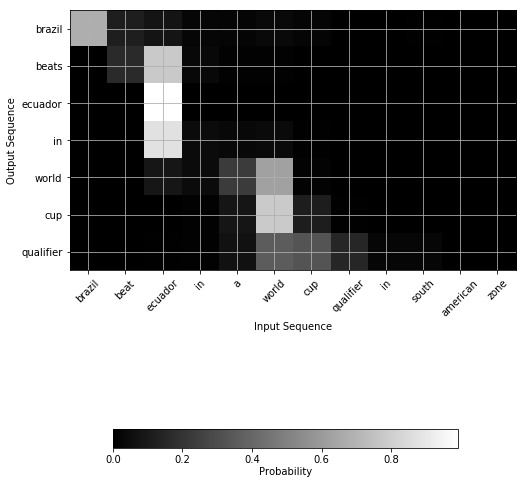

In [77]:
viz.attention_map(' '.join(np.array(id2w_ad_at)[t_ad_test_unpad_at[1766]]), t_ad_test_at[1766].reshape((1, MAX_LEN_AT)), id2w_sd_at)

#### EXPLANATION
- The attention model's summary has matched the gold standard summary, with the exception of the score, which is fine since it very well summarizes the most important part of the news article. Whereas the non-attention model was not able to correctly identify the opponents in the game. From the attention-map we can see that the model has learnt strong correlation betweem the exact countries, Brazil and Ecuador as well as learnt correlation between world and cup or essentially world cup qualifier, which is what the game was about.

#### SENTENCE-2

- I(2): asian stocks closed mostly higher tuesday following gains on wall street .
- G: most asian stock markets close higher
- NA: asian stock markets close mostly higher
- A: asian stock markets close mostly higher

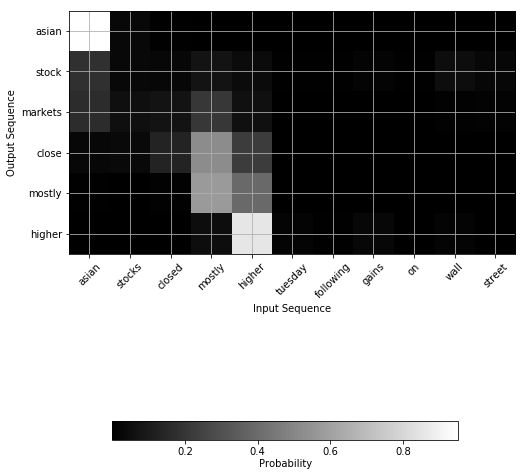

In [79]:
viz.attention_map(' '.join(np.array(id2w_ad_at)[t_ad_test_unpad_at[2761]]), t_ad_test_at[2761].reshape((1, MAX_LEN_AT)), id2w_sd_at)

#### EXPLANATION
- The attention model's summary has well summarized the article sentence. Although there is mis-placement of the word mostly between the predicted summary and gold-standard, it aligns correctly with the part of the sentence in the article sentence resulting in an extractive summary. The non-attention model has the same summary as the attention model. The attention-map shows that the model has learnt the correlation between the words 'higher', 'mostly', 'closed' with 'close' and 'asian' with 'asian'.

#### SENTENCE-3

- I(3): tokyo stocks rose wednesday , boosted by overnight gains on wall street .
- G: tokyo stocks rise dollar higher against yen in early trading
- NA: tokyo stocks up dollar higher against yen
- A: tokyo stocks rise dollar higher against yen yen

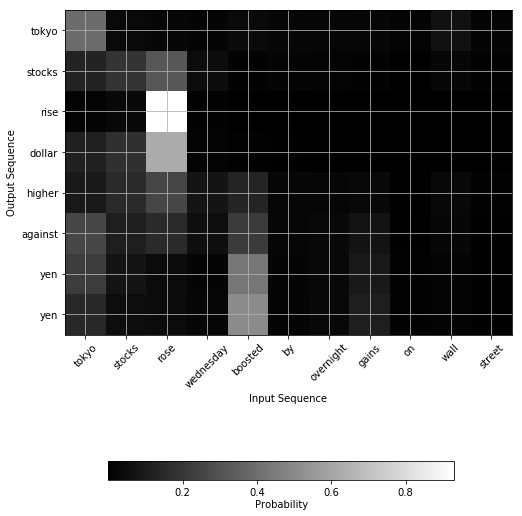

In [73]:
viz.attention_map(' '.join(np.array(id2w_ad_at)[t_ad_test_unpad_at[437]]), t_ad_test_at[437].reshape((1, MAX_LEN_AT)), id2w_sd_at)

#### EXPLANATION
- The attention model's summary has captured most of the gold-standard summary, with repetition of word 'yen', but it perfectly captures the information in the summary. The non-attention model has also produced the summary well with the word difference of 'up' vs 'rise'. The attention map shows that the model learnt well the correlations between 'rose' and 'rise', tokyo, and 'against yen' with boosted.

#### SENTENCE-4

- I(4): the taiwan stock exchange 's main index opened sharply higher wednesday .
- G: taiwan shares open sharply higher
- NA: taiwan shares open higher higher
- A: taiwan stock market opens higher

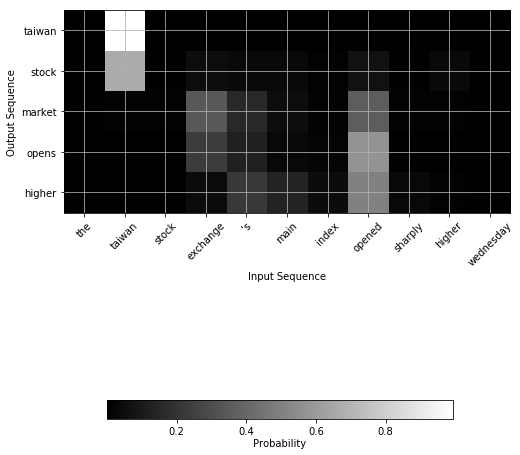

In [72]:
viz.attention_map(' '.join(np.array(id2w_ad_at)[t_ad_test_unpad_at[530]]), t_ad_test_at[530].reshape((1, MAX_LEN_AT)), id2w_sd_at)

#### EXPLANATION
- The attention model summary isnt exactly same as the gold-standard, but it preserves the meaning. Also, it is well extracted from the article sentence. Stock market and shares are used to indicate the same thing. The non-attention model summary also abstracts well, but erroneously repeats the word higher. Maybe it is used to add adjective to the word higher to indicate sharply higher. The attention-map shows model's correlation between 'opened' and 'opens' to understand tense, 'taiwan' and 'taiwan', and 'exchange' and 'market' to understand financial synonyms. 

#### SENTENCE-5

- I(5): share prices on the london stock exchange were higher at midday tuesday .
- G: london share prices up at midday
- NA: london share prices higher at midday
- A: london share prices higher midday midday

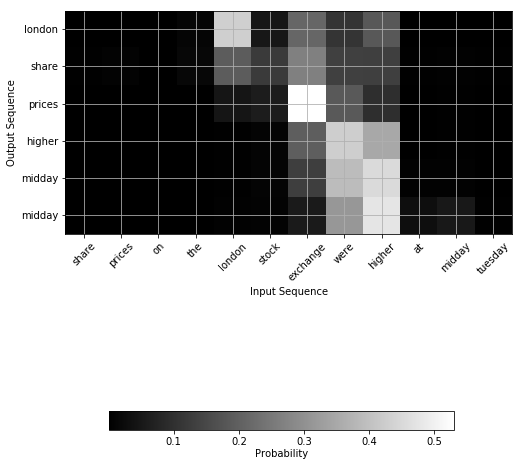

In [84]:
#viz.attention_map(text,test_data_vector,idx2word)
viz.attention_map(' '.join(np.array(id2w_ad_at)[t_ad_test_unpad_at[0]]), t_ad_test_at[0].reshape((1, MAX_LEN_AT)), id2w_sd_at)

#### EXPLANATION
- The attention model summary is almost same as gold-standard, with 1 word difference while preserving the meaning. But it's words are extracted from article sentence. Erroneously midday is repeated. The non-attention model summary produces the summary without any errors. The attention map shows the model learnt correlation between 'exchange' and 'prices', 'london' and 'london', and 'higher' and 'higher'.

## BAD SUMMARIES

#### SENTENCE-6
- I(6): the euro and the yen rose slightly against the u.s. dollar on wednesday .
- G: euro yen slightly higher against u.s. dollar
- NA: euro hits against euro dollar dollar dollar
- A: euro falls against dollar against against

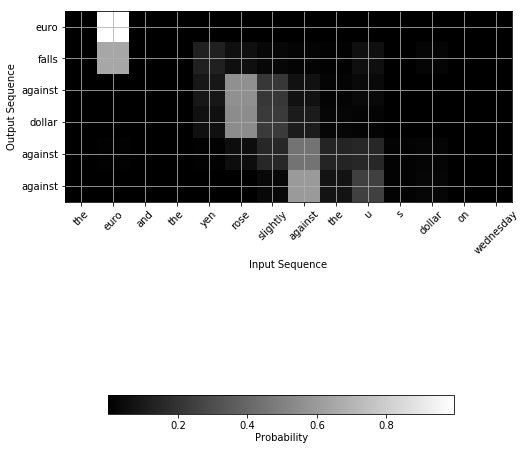

In [71]:
viz.attention_map(' '.join(np.array(id2w_ad_at)[t_ad_test_unpad_at[440]]), t_ad_test_at[440].reshape((1, MAX_LEN_AT)), id2w_sd_at)

#### EXPLANATION
-  The attention model summary is clearly opposite in meaning of the gold-standard, hence a bad summary. The non-attention model summary is erroneous in repeating words and producing a meaningless statement. The attention-map shows that the model learnt the few correlations like 'euro' and 'euro', and 'against' and 'against'.

#### SENTENCE-7
- I(7): the dollar gained on most other major currencies in light trading thursday .
- G: dollar ends mostly higher
- NA: dollar rises against currencies
- A: dollar up gold up

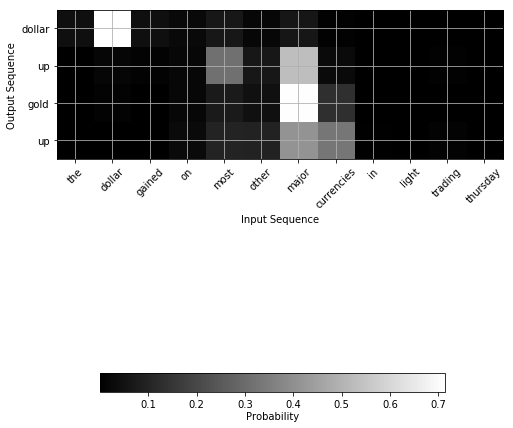

In [57]:
viz.attention_map(' '.join(np.array(id2w_ad_at)[t_ad_test_unpad_at[6992]]), t_ad_test_at[6992].reshape((1, MAX_LEN_AT)), id2w_sd_at)

#### EXPLANATION
- The attention model summary does not make any sense. Also, the non-attention model summary abstracts well in meaning from the article sentence and matches in meaning with the gold-standard, but not in words. This is very interesting since, this might reduce the rouge-score indicating a poorly learnt system whereas infact the system abstracts good summaries. The attention-map also shows few well the model learnt correlations like 'dollar' with 'dollar'. 

#### SENTENCE-8
- I(8): tropical storm sergio weakened late friday as it headed out to the pacific .
- G: tropical storm sergio weakens and heads out to sea
- NA: tropical storm unk becomes in the
- A: tropical storm unk to to pacific pacific

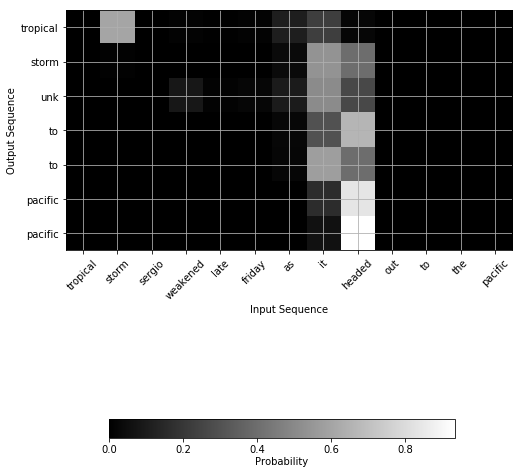

In [58]:
viz.attention_map(' '.join(np.array(id2w_ad_at)[t_ad_test_unpad_at[6995]]), t_ad_test_at[6995].reshape((1, MAX_LEN_AT)), id2w_sd_at)

#### EXPLANATION
- The attention summary is missing details and does not make sense (bad summary). The non-attention summary seems to be in the right direction but does not complete the information. The attention map shows kind of a sequential correlation. 'storm' correlates with 'tropical' and 'headed' correlates with 'pacific'.

#### SENTENCE-9
- I(9): wales drew ##-## with fiji in a rugby test at millennium stadium on friday .
- G: wales draws with fiji ##-##
- NA: wales draws with nations against match match
- A: wales draws wales result

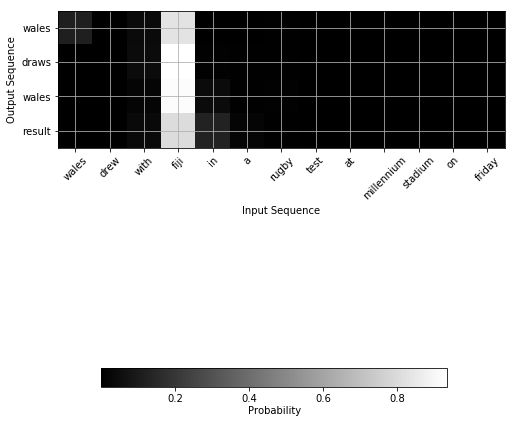

In [59]:
viz.attention_map(' '.join(np.array(id2w_ad_at)[t_ad_test_unpad_at[6985]]), t_ad_test_at[6985].reshape((1, MAX_LEN_AT)), id2w_sd_at)

#### EXPLANATION
- The attention summary does not convey much meaning. Seems like the 2nd 'wales' could have been 'fiji', as the attention map correlates. The attention map also shows a very dull correlation between 'wales' and 'wales'. The non-attention summary is also meaningless. 

#### SENTENCE-10
- I(10): mexican stocks closed lower thursday , dragged down again by u.s. bears .
- G: stocks finish down in mexico chile ; rise sharply in argentina
- NA: stocks down in mexico argentina chile in in chile
- A: stocks down lower in lower

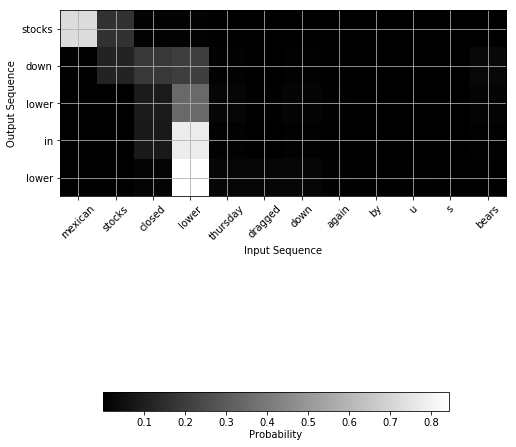

In [60]:
viz.attention_map(' '.join(np.array(id2w_ad_at)[t_ad_test_unpad_at[6]]), t_ad_test_at[6].reshape((1, MAX_LEN_AT)), id2w_sd_at)

#### EXPLANATION
- The attention summary isn't completely meaningful (bad summary). The non-attention summary is meaningful but presents wrong information compared to gold-standard summary. The attention-map correlates 'lower' with 'lower', 'mexican' with 'stocks' which is correct, and 'closed lower' with 'down'. So, the model seems to have learnt good correlations. 

## RANDOM SUMMARIES

#### SENTENCE-11

- I(11): australian stocks closed predictably lower after a day of quiet trading .
- G: australian stocks end lower
- NA: australian stocks close lower
- A: australian stocks close lower

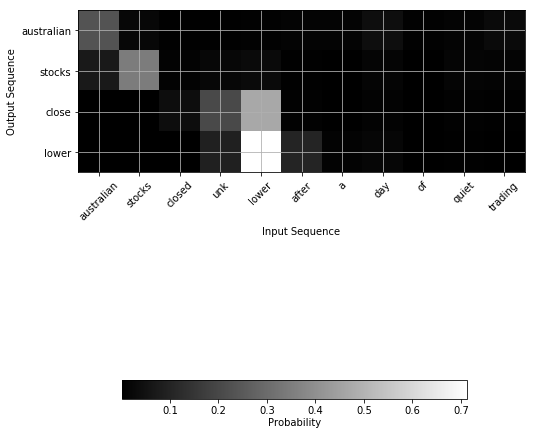

In [75]:
viz.attention_map(' '.join(np.array(id2w_ad_at)[t_ad_test_unpad_at[1620]]), t_ad_test_at[1620].reshape((1, MAX_LEN_AT)), id2w_sd_at)

#### EXPLANATION
- The attention model and non-attention model summary are the same and almost exactly as the gold-standard (good summary) with the difference of 1 word (end vs close) where synonyms are used, and extracted from the article sentence. The attention-map also shows that the model learn decent correlations like 'lower' and 'lower', 'stocks' and 'stocks', and 'australian' and 'australian'. 

#### SENTENCE-12
- I(12): israel appointed its first arab as a judge on the supreme court tuesday .
- G: first arab judge joins israeli supreme court
- NA: israel 's israel unk on law unk
- A: israel unk unk unk in court

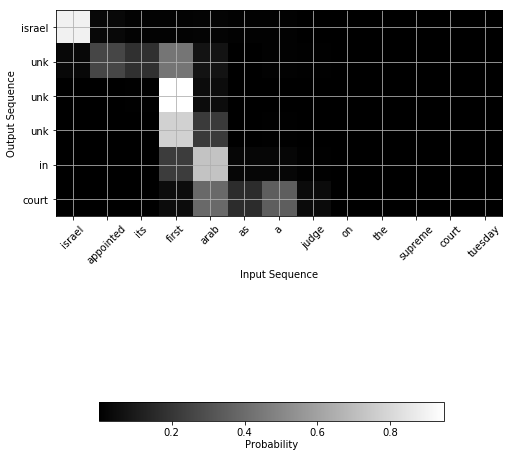

In [61]:
viz.attention_map(' '.join(np.array(id2w_ad_at)[t_ad_test_unpad_at[26]]), t_ad_test_at[26].reshape((1, MAX_LEN_AT)), id2w_sd_at)

#### EXPLANATION
- The attention summary produces repeated unk and is meaningless (bad summary). Same is the case with the non-attention summary. The attention-map correctly correlates only 'israel', but not other words. 

#### SENTENCE-13
- I(13): share prices on the london stock exchange rose by #.# percent wednesday .
- G: london share prices close higher
- NA: london share prices index up points
- A: london share prices up

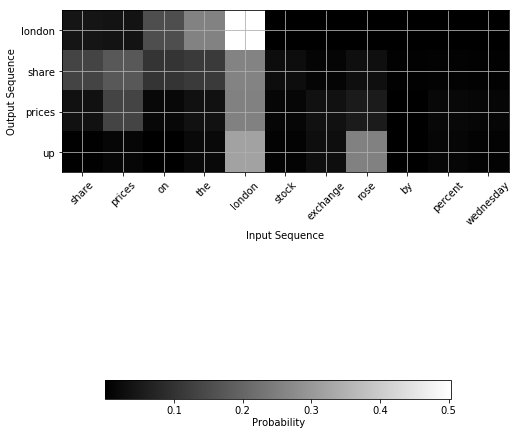

In [65]:
viz.attention_map(' '.join(np.array(id2w_ad_at)[t_ad_test_unpad_at[49]]), t_ad_test_at[49].reshape((1, MAX_LEN_AT)), id2w_sd_at)

#### EXPLANATION
- The attention summary is quite accurate given the gold-standard (good summary). The non-attention summary is also good, but slightly ambiguous. The attention-map shows good correlations learnt by the model, like 'london' with 'london', 'rose' with 'up', and 'share prices' with 'share prices'. 

#### SENTENCE-14
- I(14): former swiss president ernst brugger has died , it was announced monday .
- G: former swiss president ernst unk dies at ##
- NA: former czech unk unk unk dies at
- A: former unk president president dies dies

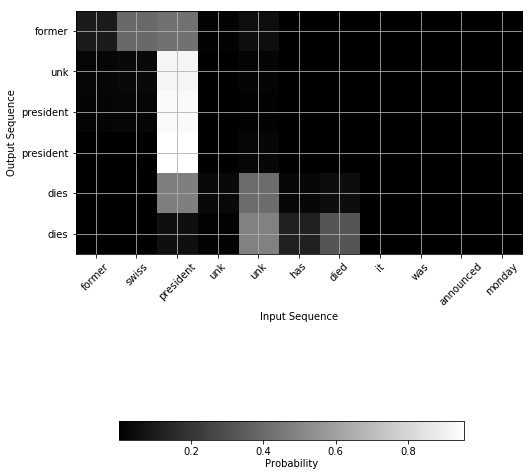

In [66]:
viz.attention_map(' '.join(np.array(id2w_ad_at)[t_ad_test_unpad_at[102]]), t_ad_test_at[102].reshape((1, MAX_LEN_AT)), id2w_sd_at)

#### EXPLANATION
- The attention summary only produces slight meaning and misses key information like, which president. Whereas, the non-attention summary produces false information in terms of czech president. The attention-map has learnt some useful correlations like tense in 'died' vs 'dies', and the usual 'president' with 'president'.

#### SENTENCE-15
- I(15): lewis hamilton took the pole again at the canadian grand prix -- barely .
- G: lewis hamilton takes another canadian gp pole
- NA: pole wins for at grand prix
- A: newman fastest pole pole pole at

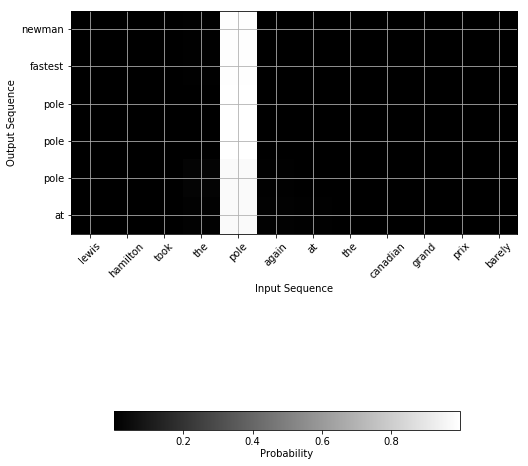

In [67]:
viz.attention_map(' '.join(np.array(id2w_ad_at)[t_ad_test_unpad_at[107]]), t_ad_test_at[107].reshape((1, MAX_LEN_AT)), id2w_sd_at)

#### EXPLANATION
- The attention summary is completely meaningless and has repeated words (bad summary). The non-attention summary has more variety of words but is also meaningless. So, the attention-map also shows poor correlations, 'pole' correlates with all the words in the summary!

## PROBLEMS AND SUGGESTIONS
- The non-attention model produces summaries that have much more variety of words, but they are mostly out of place and meaningless, and usually talk about un-correlated articles. The attention model on the other hand, produces repeated words more frequently, when it is seemingly unsure of the context (maybe because of the reduced vocabulary of words to choose from), but its summaries are much more in context and replete with information. 
- The attention model summaries seem to perform extraction of verbs and pronouns from the articles, unlike the non-attention model summaries. And so some really good summaries (which summarize the article perfectly) differ from the gold-standard summaries by just those few words, thus impacting the rouge-score. 
- Seeing the rouge scores of the attention and non-attention model it is prevalent that the attention helps the model learn better and produce better summaries, inspite of using a smaller vocabulary of words.  
#### .
- Seemingly, a limited vocab reduces the ability of the model to produce good summaries, since it has fewer words in which it can express.
- It is practically impossible to feed in the largest possible vocabulary and even that would not contain all the possible words in the universe.
- One way around this is to move a different level of vocabulary creation and that is character level vocabulary. Here each character in the sentence would be encoded separately, rather than the whole word. And since 'space' character would also be encoded, it would help in separating out the words. The character level vocab is much smaller, containing only 69 possible characters that can be typed by the keyboard. Although, this would increase the length of the encoded sentence, since the vocab vector is small, the overall encoded matrix would be much smaller and possibly even reduce memory usage. 
- Character level encoding would help to preserve the sentence as is, when encoded, including all the punctuations and mis-spellings of the same word, that would have been difficult to include using word-level based vocab.
- There could be 2 ways to train on these vectors:
    - Use CNNs to extract 1st level of features and then an encoder-decoder architecture on top.
    - Use encoder-decoder architecture directly. 
    - Arguably the model would have many more transitions to learn, but since the inputs are much smaller, the hidden_dimensions can be increased to accomodate those many transitions. Also, bidirectional LSTMs would really help in improving the learning of these increased transitions. And rather than using vanilla LSTMs, GRUs can be used to learn and preserve longer transitions. 
- Character level encodings have shown promising results in text classification tasks and it would be interesting to see how they perform in translation and summarization tasks.

###### REFERENCES: Zhang, X. and LeCun, Y., 2015. Text understanding from scratch. arXiv preprint arXiv:1502.01710.

# Unidirectional LSTM Encoder Decoder With Attention and Beam Search (Extra Credit)

The models that you implemented till now had greedy decoder. Now implement a Decoder with Beam Search and show improved results

In [ ]:
## Beam search on the final model.predict Keras beam search